<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/v2_Optimizacion_Red_Distribucion_Pyomo_GLPK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GitHub Link: https://github.com/jrebull/AMLM/blob/main/Optimizacion_Red_Distribucion_Pyomo_GLPK.ipynb

# Optimización de Red Multinivel de Distribución Multiproducto

---

## Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD)
### Universidad Autónoma de Ciudad Juárez (UACJ)

**Profesor:** Dr. Gilberto Rivera Zárate  
**Curso:** Programación para Analítica Prescriptiva y Soporte a Decisiones  
**Fecha de Entrega:** Jueves 20 de Noviembre 2025

---

## Alumnos

**PATRICIA MARIA ROSAS CALDERON** - al261538@alumnos.uacj.mx  
**MANUEL FLORES CACHO** - al263178@alumnos.uacj.mx  
**JAVIER AUGUSTO REBULL SAUCEDO** - al263483@alumnos.uacj.mx

---

## Proyecto Final

---

## Objetivo del Proyecto

Desarrollar e implementar un modelo de optimización lineal para diseñar una red logística multinivel que minimice los costos totales de operación en una cadena de suministro compuesta por plantas manufactureras, centros de distribución y una red de clientes.

El modelo considera restricciones de capacidad de producción y almacenamiento, balance de flujo en centros de distribución, y satisfacción completa de la demanda de clientes, utilizando Pyomo como framework de modelado y GLPK como solver de programación lineal.

---

## Tecnologías Utilizadas

![Python](https://img.shields.io/badge/Python-3.8+-3776AB?style=flat-square&logo=python&logoColor=white)
![Pyomo](https://img.shields.io/badge/Pyomo-6.0+-FF6F00?style=flat-square&logo=buffer&logoColor=white)
![GLPK](https://img.shields.io/badge/GLPK-Solver-008000?style=flat-square&logo=gnu&logoColor=white)
![Pandas](https://img.shields.io/badge/Pandas-1.5+-150458?style=flat-square&logo=pandas&logoColor=white)
![NumPy](https://img.shields.io/badge/NumPy-1.24+-013243?style=flat-square&logo=numpy&logoColor=white)
![Matplotlib](https://img.shields.io/badge/Matplotlib-3.7+-11557c?style=flat-square&logo=plotly&logoColor=white)
![Seaborn](https://img.shields.io/badge/Seaborn-0.12+-444876?style=flat-square&logo=python&logoColor=white)
![Colab](https://img.shields.io/badge/Google-Colab-F9AB00?style=flat-square&logo=googlecolab&logoColor=white)

---

## Tabla de Contenidos

1. **Instalación y Configuración**
2. **Descarga y Carga de Datos**
3. **Exploración de Datos**
4. **Definición de Conjuntos y Parámetros**
5. **Formulación Matemática del Modelo**
6. **Construcción del Modelo con Pyomo**
7. **Resolución del Modelo**
8. **Análisis de Resultados**
9. **Validación de la Solución**
10. **Visualización de Resultados**
11. **Conclusiones**

---

## 1. Instalación de Paquetes Necesarios

#Celda 01

In [1]:
# ============================================================
# INSTALACIÓN SILENCIOSA DE GLPK
# ============================================================

# Limpiar y instalar en silencio
!apt-get remove -y glpk-utils &> /dev/null || true
!apt-get update -qq &> /dev/null
!apt-get install -y glpk-utils libglpk-dev &> /dev/null

# Buscar glpsol
import subprocess
result = subprocess.run(['which', 'glpsol'], capture_output=True, text=True)

if result.stdout.strip():
    glpsol_path = result.stdout.strip()

    # Probar con Pyomo
    import pyomo.environ as pyo
    from pyomo.opt import SolverFactory

    solver = SolverFactory('glpk', executable=glpsol_path)

    if solver.available():
        # Modelo de prueba
        model = pyo.ConcreteModel()
        model.x = pyo.Var(domain=pyo.NonNegativeReals)
        model.obj = pyo.Objective(expr=model.x, sense=pyo.minimize)
        model.con = pyo.Constraint(expr=model.x >= 1)

        result = solver.solve(model, tee=False)

        if result.solver.termination_condition == pyo.TerminationCondition.optimal:
            print("✅ ¡GLPK DISPONIBLE EN PYOMO!")
            print(f"✅ Solución de prueba: x = {pyo.value(model.x):.2f}")
            print(f"\n🎯 USA ESTA RUTA EN TU CÓDIGO: {glpsol_path}")
        else:
            print("⚠️ GLPK: Solver responde pero con problemas")
    else:
        print("❌ GLPK: Pyomo no detecta GLPK")
else:
    print("❌ GLPK: glpsol no encontrado después de instalación")
    print("\n💡 Solución: Usa CBC que ya funciona:")
    print("   lp_model.solve(solver_name='cbc', time_limit=300)")

✅ ¡GLPK DISPONIBLE EN PYOMO!
✅ Solución de prueba: x = 1.00

🎯 USA ESTA RUTA EN TU CÓDIGO: /usr/bin/glpsol


## 2. Descargar Datos desde Google Drive

# Celda 02

In [2]:
import gdown
import pandas as pd
import numpy as np
from pyomo.environ import *

# IDs de archivos en Google Drive
archivos = {
    'plantas.csv': '1sm2UYkaeETYnh-nIykTHO3jrRUVzMbmP',
    'centros.csv': '1weTwr_qTtHqpTbscixP-6FweCpvySiOv',
    'clientes.csv': '1RRlz8U0f-TOmYL_1EovJJKlw-DC2YRLI',
    'Costos Plantas x CeDis.csv': '1JiYe20Y0lq5LJOHgNjlB0cOk7augwyZl',
    'Costos CeDis x Cliente.csv': '1MU5Y-vY_Xv_X7AlP_xYsw8p9opqVtkDX'
}

# Descargar archivos
print("Descargando archivos...")
for nombre, file_id in archivos.items():
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, nombre, quiet=False)
    print(f"✓ {nombre} descargado")

Descargando archivos...


Downloading...
From: https://drive.google.com/uc?id=1sm2UYkaeETYnh-nIykTHO3jrRUVzMbmP
To: /content/plantas.csv
100%|██████████| 527/527 [00:00<00:00, 1.53MB/s]


✓ plantas.csv descargado


Downloading...
From: https://drive.google.com/uc?id=1weTwr_qTtHqpTbscixP-6FweCpvySiOv
To: /content/centros.csv
100%|██████████| 1.30k/1.30k [00:00<00:00, 720kB/s]


✓ centros.csv descargado


Downloading...
From: https://drive.google.com/uc?id=1RRlz8U0f-TOmYL_1EovJJKlw-DC2YRLI
To: /content/clientes.csv
100%|██████████| 12.8k/12.8k [00:00<00:00, 23.1MB/s]


✓ clientes.csv descargado


Downloading...
From: https://drive.google.com/uc?id=1JiYe20Y0lq5LJOHgNjlB0cOk7augwyZl
To: /content/Costos Plantas x CeDis.csv
100%|██████████| 581/581 [00:00<00:00, 2.05MB/s]


✓ Costos Plantas x CeDis.csv descargado


Downloading...
From: https://drive.google.com/uc?id=1MU5Y-vY_Xv_X7AlP_xYsw8p9opqVtkDX
To: /content/Costos CeDis x Cliente.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 13.6MB/s]

✓ Costos CeDis x Cliente.csv descargado


## 3. Cargar y Explorar los Datos

In [3]:
# Cargar datos
df_plantas = pd.read_csv('plantas.csv')
df_centros = pd.read_csv('centros.csv')
df_clientes = pd.read_csv('clientes.csv')
df_costos_plantas = pd.read_csv('Costos Plantas x CeDis.csv')
df_costos_centros = pd.read_csv('Costos CeDis x Cliente.csv')

print("=" * 60)
print("DATOS CARGADOS")
print("=" * 60)
print(f"Plantas: {len(df_plantas)} registros")
print(f"Centros: {len(df_centros)} registros")
print(f"Clientes: {len(df_clientes)} registros")
print(f"Costos Plantas x CeDis: {len(df_costos_plantas)} registros")
print(f"Costos CeDis x Cliente: {len(df_costos_centros)} registros")

DATOS CARGADOS
Plantas: 15 registros
Centros: 50 registros
Clientes: 500 registros
Costos Plantas x CeDis: 15 registros
Costos CeDis x Cliente: 50 registros


In [4]:
print("\n📋 Estructura de Plantas:")
print(df_plantas.head())
print(df_plantas.columns.tolist())

print("\n📋 Estructura de Centros:")
print(df_centros.head())
print(df_centros.columns.tolist())

print("\n📋 Estructura de Clientes:")
print(df_clientes.head())
print(df_clientes.columns.tolist())

print("\n📋 Estructura de Costos Plantas x CeDis:")
print(df_costos_plantas.head())
print(df_costos_plantas.columns.tolist())

print("\n📋 Estructura de Costos CeDis x Cliente:")
print(df_costos_centros.head())
print(df_costos_centros.columns.tolist())


📋 Estructura de Plantas:
     Planta    Producto  Capacidad_Produccion  Costo_Produccion
0  Planta_1  Producto_1                  6685             12.26
1  Planta_1  Producto_2                 11949             10.03
2  Planta_1  Producto_3                 10051             17.34
3  Planta_1  Producto_4                  9555             34.47
4  Planta_1  Producto_5                 11396             27.28
['Planta', 'Producto', 'Capacidad_Produccion', 'Costo_Produccion']

📋 Estructura de Centros:
     Centro    Producto  Capacidad_Almacenamiento
0  Centro_1  Producto_1                      5612
1  Centro_1  Producto_2                      4363
2  Centro_1  Producto_3                      9235
3  Centro_1  Producto_4                      8486
4  Centro_1  Producto_5                      4478
['Centro', 'Producto', 'Capacidad_Almacenamiento']

📋 Estructura de Clientes:
     Cliente    Producto  Demanda
0  Cliente_1  Producto_1       64
1  Cliente_1  Producto_2       84
2  Cliente_1  Pro

## 4. Definir Conjuntos y Parámetros

In [5]:
# ==================== CONJUNTOS Y PARÁMETROS ====================
# Extraer conjuntos únicos
P = sorted(df_plantas['Planta'].unique())  # Plantas
C = sorted(df_centros['Centro'].unique())  # Centros de distribución
J = sorted(df_clientes['Cliente'].unique())  # Clientes
K = sorted(df_plantas['Producto'].unique())  # Productos

print(f"Plantas (P): {len(P)} - {P}")
print(f"Centros (C): {len(C)} - {C}")
print(f"Clientes (J): {len(J)} - {J}")
print(f"Productos (K): {len(K)} - {K}")

Plantas (P): 3 - ['Planta_1', 'Planta_2', 'Planta_3']
Centros (C): 10 - ['Centro_1', 'Centro_10', 'Centro_2', 'Centro_3', 'Centro_4', 'Centro_5', 'Centro_6', 'Centro_7', 'Centro_8', 'Centro_9']
Clientes (J): 100 - ['Cliente_1', 'Cliente_10', 'Cliente_100', 'Cliente_11', 'Cliente_12', 'Cliente_13', 'Cliente_14', 'Cliente_15', 'Cliente_16', 'Cliente_17', 'Cliente_18', 'Cliente_19', 'Cliente_2', 'Cliente_20', 'Cliente_21', 'Cliente_22', 'Cliente_23', 'Cliente_24', 'Cliente_25', 'Cliente_26', 'Cliente_27', 'Cliente_28', 'Cliente_29', 'Cliente_3', 'Cliente_30', 'Cliente_31', 'Cliente_32', 'Cliente_33', 'Cliente_34', 'Cliente_35', 'Cliente_36', 'Cliente_37', 'Cliente_38', 'Cliente_39', 'Cliente_4', 'Cliente_40', 'Cliente_41', 'Cliente_42', 'Cliente_43', 'Cliente_44', 'Cliente_45', 'Cliente_46', 'Cliente_47', 'Cliente_48', 'Cliente_49', 'Cliente_5', 'Cliente_50', 'Cliente_51', 'Cliente_52', 'Cliente_53', 'Cliente_54', 'Cliente_55', 'Cliente_56', 'Cliente_57', 'Cliente_58', 'Cliente_59', 'Clie

In [6]:
# ============================================================================
# CREAR DICCIONARIOS PARA PARÁMETROS
# ============================================================================

# Demanda de clientes: d[j,k]
demanda = {}
for _, row in df_clientes.iterrows():
    demanda[(row['Cliente'], row['Producto'])] = row['Demanda']

# Capacidad de producción: cap_prod[p,k]
cap_produccion = {}
for _, row in df_plantas.iterrows():
    cap_produccion[(row['Planta'], row['Producto'])] = row['Capacidad_Produccion']

# Capacidad de almacenamiento: cap_alm[c,k]
cap_almacenamiento = {}
for _, row in df_centros.iterrows():
    cap_almacenamiento[(row['Centro'], row['Producto'])] = row['Capacidad_Almacenamiento']

# Costo de producción: cost_prod[p,k]
costo_produccion = {}
for _, row in df_plantas.iterrows():
    costo_produccion[(row['Planta'], row['Producto'])] = row['Costo_Produccion']

# Costo de transporte Planta→Centro: cost_pc[p,c,k]
# Transformar df_costos_plantas de formato ancho a diccionario
costo_planta_centro = {}
for _, row in df_costos_plantas.iterrows():
    planta = f"Planta_{int(row['Planta'])}"
    producto = f"Producto_{int(row['Producto '])}"  # Nota: 'Producto ' con espacio
    for i in range(1, 11):  # centro1 a centro10
        centro = f"Centro_{i}"
        costo = row[f'centro{i}']
        costo_planta_centro[(planta, centro, producto)] = costo

# Costo de transporte Centro→Cliente: cost_cj[c,j,k]
# Transformar df_costos_centros de formato ancho a diccionario
costo_centro_cliente = {}
for _, row in df_costos_centros.iterrows():
    producto = f"Producto_{int(row['Producto'])}"
    centro = f"Centro_{int(row['Centro'])}"
    for i in range(1, 101):  # Cliente1 a Cliente100
        cliente = f"Cliente_{i}"
        costo = row[f'Cliente{i}']
        costo_centro_cliente[(centro, cliente, producto)] = costo

# Verificar tamaños
print("\n✓ Diccionarios de parámetros creados:")
print(f"   demanda: {len(demanda)} entradas")
print(f"   cap_produccion: {len(cap_produccion)} entradas")
print(f"   cap_almacenamiento: {len(cap_almacenamiento)} entradas")
print(f"   costo_produccion: {len(costo_produccion)} entradas")
print(f"   costo_planta_centro: {len(costo_planta_centro)} entradas")
print(f"   costo_centro_cliente: {len(costo_centro_cliente)} entradas")

# Verificar que los costos ahora coincidan
print("\n🔍 Verificación rápida:")
p, c, k = P[0], C[0], K[0]
dict_costo_pc = costo_planta_centro.get((p, c, k), 0)
dict_costo_cj = costo_centro_cliente.get((c, J[0], k), 0)
print(f"   Costo {p} → {c} ({k}): ${dict_costo_pc:.2f}")
print(f"   Costo {c} → {J[0]} ({k}): ${dict_costo_cj:.2f}")
print("   ✅ Diccionarios creados correctamente")


✓ Diccionarios de parámetros creados:
   demanda: 500 entradas
   cap_produccion: 15 entradas
   cap_almacenamiento: 50 entradas
   costo_produccion: 15 entradas
   costo_planta_centro: 150 entradas
   costo_centro_cliente: 5000 entradas

🔍 Verificación rápida:
   Costo Planta_1 → Centro_1 (Producto_1): $10.00
   Costo Centro_1 → Cliente_1 (Producto_1): $9.00
   ✅ Diccionarios creados correctamente


## 5. Crear Modelo de Optimización con Pyomo

In [7]:
# Crear modelo concreto
modelo = ConcreteModel(name="Red_Distribucion_Multinivel")

# ==================== CONJUNTOS ====================
modelo.P = Set(initialize=P)  # Plantas
modelo.C = Set(initialize=C)  # Centros
modelo.J = Set(initialize=J)  # Clientes
modelo.K = Set(initialize=K)  # Productos

print("✓ Conjuntos definidos")

✓ Conjuntos definidos


In [8]:
# ==================== VARIABLES DE DECISIÓN ====================
# x[p,c,k]: Cantidad de producto k enviada de planta p a centro c
modelo.x = Var(modelo.P, modelo.C, modelo.K, within=NonNegativeReals)

# y[c,j,k]: Cantidad de producto k enviada de centro c a cliente j
modelo.y = Var(modelo.C, modelo.J, modelo.K, within=NonNegativeReals)

print("✓ Variables de decisión definidas")

✓ Variables de decisión definidas


In [9]:
# ==================== FUNCIÓN OBJETIVO ====================
def funcion_objetivo(m):
    # Costo de producción + transporte planta->centro
    costo_plantas = sum(
        (costo_produccion.get((p, k), 0) + costo_planta_centro.get((p, c, k), 0)) * m.x[p, c, k]
        for p in m.P for c in m.C for k in m.K
    )

    # Costo de transporte centro->cliente
    costo_centros = sum(
        costo_centro_cliente.get((c, j, k), 0) * m.y[c, j, k]
        for c in m.C for j in m.J for k in m.K
    )

    return costo_plantas + costo_centros

modelo.objetivo = Objective(rule=funcion_objetivo, sense=minimize)
print("✓ Función objetivo definida (minimización de costos)")

✓ Función objetivo definida (minimización de costos)


In [10]:
# ==================== RESTRICCIONES ====================

# 1. SATISFACCIÓN DE DEMANDA: Cada cliente recibe lo que necesita
def restriccion_demanda(m, j, k):
    if demanda.get((j, k), 0) > 0:  # Solo si hay demanda
        return sum(m.y[c, j, k] for c in m.C) == demanda.get((j, k), 0)
    else:
        return Constraint.Skip

modelo.satisfacer_demanda = Constraint(modelo.J, modelo.K, rule=restriccion_demanda)

print("✓ Restricción 1: Satisfacción de demanda")

✓ Restricción 1: Satisfacción de demanda


In [11]:
# 2. BALANCE DE FLUJO: Lo que entra al centro = lo que sale
def restriccion_balance(m, c, k):
    entrada = sum(m.x[p, c, k] for p in m.P)
    salida = sum(m.y[c, j, k] for j in m.J)
    return entrada == salida

modelo.balance_centros = Constraint(modelo.C, modelo.K, rule=restriccion_balance)
print("✓ Restricción 2: Balance de flujo en centros")

✓ Restricción 2: Balance de flujo en centros


In [12]:
# 3. CAPACIDAD DE PRODUCCIÓN: No exceder capacidad de plantas
def restriccion_capacidad_planta(m, p, k):
    if (p, k) in cap_produccion:  # Solo si existe capacidad definida
        return sum(m.x[p, c, k] for c in m.C) <= cap_produccion[(p, k)]
    else:
        return Constraint.Skip

modelo.capacidad_plantas = Constraint(modelo.P, modelo.K, rule=restriccion_capacidad_planta)
print("✓ Restricción 3: Capacidad de producción")

✓ Restricción 3: Capacidad de producción


In [13]:
# 4. CAPACIDAD DE ALMACENAMIENTO: No exceder capacidad de centros
def restriccion_capacidad_centro(m, c, k):
    if (c, k) in cap_almacenamiento:
        return sum(m.y[c, j, k] for j in m.J) <= cap_almacenamiento[(c, k)]
    else:
        return Constraint.Skip

modelo.capacidad_centros = Constraint(modelo.C, modelo.K, rule=restriccion_capacidad_centro)
print("✓ Restricción 4: Capacidad de almacenamiento")

✓ Restricción 4: Capacidad de almacenamiento


# Visualizacion del Modelo

In [14]:
# ============================================================================
# 📐 FORMULACIÓN MATEMÁTICA DEL PROBLEMA (VERSIÓN DARK MODE)
# ============================================================================

from IPython.display import HTML, Markdown, display

# Calcular dimensiones del modelo
num_plantas = len(P)
num_centros = len(C)
num_clientes = len(J)
num_productos = len(K)

num_vars_x = num_plantas * num_centros * num_productos
num_vars_y = num_centros * num_clientes * num_productos
total_vars = num_vars_x + num_vars_y

# CSS para estilos (Dark Mode)
css = """
<style>
.sets-box, .params-box, .vars-box, .constraint-box {
    color: #e0e0e0;
}
.math-box {
    background: linear-gradient(135deg, #5a68c2 0%, #613b82 100%);
    border-radius: 10px;
    padding: 20px;
    margin: 20px 0;
    color: white;
    box-shadow: 0 4px 6px rgba(0,0,0,0.3);
}
.constraint-box {
    background: #2c2c2c;
    border-left: 4px solid #5da5f5;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
.objective-box {
    background: linear-gradient(135deg, #d479df 0%, #e04a5c 100%);
    border-radius: 10px;
    padding: 20px;
    margin: 20px 0;
    color: white;
    box-shadow: 0 4px 6px rgba(0,0,0,0.3);
}
.sets-box {
    background: #2e3b2e;
    border-left: 4px solid #81c784;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
.params-box {
    background: #3e3529;
    border-left: 4px solid #ffb74d;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
.vars-box {
    background: #2b3740;
    border-left: 4px solid #64b5f6;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
h3 {
    margin-top: 30px;
    color: #e8e8e8;
    border-bottom: 3px solid #764ba2;
    padding-bottom: 10px;
}
.highlight {
    background: #ffeb3b;
    padding: 2px 6px;
    border-radius: 3px;
    color: #000;
    font-weight: bold;
}
</style>
"""

display(HTML(css))

# Título principal
display(Markdown("""
# 🎯 Formulación Matemática Completa
## Problema de Optimización de Red de Distribución Multinivel
"""))

# Conjuntos
display(HTML(f"""
<div class="sets-box">
<h3>📦 CONJUNTOS (Índices)</h3>
<ul style="list-style-type: none; padding-left: 0;">
    <li><strong>P</strong>: Conjunto de <span class="highlight">plantas manufactureras</span>, indexadas por <em>p</em>
        → <strong>{num_plantas}</strong> plantas</li>
    <li><strong>C</strong>: Conjunto de <span class="highlight">centros de distribución</span>, indexados por <em>c</em>
        → <strong>{num_centros}</strong> centros</li>
    <li><strong>J</strong>: Conjunto de <span class="highlight">clientes</span>, indexados por <em>j</em>
        → <strong>{num_clientes}</strong> clientes</li>
    <li><strong>K</strong>: Conjunto de <span class="highlight">productos</span>, indexados por <em>k</em>
        → <strong>{num_productos}</strong> productos</li>
</ul>
</div>
"""))

# Parámetros
display(HTML(f"""
<div class="params-box">
<h3>📊 PARÁMETROS (Datos del Problema)</h3>
<table style="width:100%; border-collapse: collapse;">
<tr style="border-bottom: 2px solid #ffb74d;">
    <th style="text-align:left; padding:10px;">Parámetro</th>
    <th style="text-align:left; padding:10px;">Descripción</th>
    <th style="text-align:right; padding:10px;">Dimensión</th>
</tr>
<tr>
    <td style="padding:8px;"><strong>d<sub>j,k</sub></strong></td>
    <td style="padding:8px;">Demanda del cliente <em>j</em> para el producto <em>k</em></td>
    <td style="text-align:right; padding:8px;">{num_clientes} × {num_productos}</td>
</tr>
<tr style="background:#3a3024;">
    <td style="padding:8px;"><strong>cap<sup>prod</sup><sub>p,k</sub></strong></td>
    <td style="padding:8px;">Capacidad máxima de producción del producto <em>k</em> en la planta <em>p</em></td>
    <td style="text-align:right; padding:8px;">{num_plantas} × {num_productos}</td>
</tr>
<tr>
    <td style="padding:8px;"><strong>cap<sup>alm</sup><sub>c,k</sub></strong></td>
    <td style="padding:8px;">Capacidad máxima de almacenamiento del producto <em>k</em> en el centro <em>c</em></td>
    <td style="text-align:right; padding:8px;">{num_centros} × {num_productos}</td>
</tr>
<tr style="background:#3a3024;">
    <td style="padding:8px;"><strong>cost<sup>prod</sup><sub>p,k</sub></strong></td>
    <td style="padding:8px;">Costo de producción por unidad del producto <em>k</em> en la planta <em>p</em></td>
    <td style="text-align:right; padding:8px;">{num_plantas} × {num_productos}</td>
</tr>
<tr>
    <td style="padding:8px;"><strong>cost<sup>pc</sup><sub>p,c,k</sub></strong></td>
    <td style="padding:8px;">Costo de transporte por unidad del producto <em>k</em> desde planta <em>p</em> al centro <em>c</em></td>
    <td style="text-align:right; padding:8px;">{num_plantas} × {num_centros} × {num_productos}</td>
</tr>
<tr style="background:#3a3024;">
    <td style="padding:8px;"><strong>cost<sup>cj</sup><sub>c,j,k</sub></strong></td>
    <td style="padding:8px;">Costo de transporte por unidad del producto <em>k</em> desde centro <em>c</em> al cliente <em>j</em></td>
    <td style="text-align:right; padding:8px;">{num_centros} × {num_clientes} × {num_productos}</td>
</tr>
</table>
</div>
"""))

# Variables
display(HTML(f"""
<div class="vars-box">
<h3>🔢 VARIABLES DE DECISIÓN</h3>
<ul style="list-style-type: none; padding-left: 0;">
    <li><strong>x<sub>p,c,k</sub></strong> ≥ 0: Cantidad del producto <em>k</em> enviada de la planta <em>p</em> al centro <em>c</em>
        <br><em style="color:#a0a0a0;">Total de variables: <strong>{num_vars_x:,}</strong></em></li>
    <br>
    <li><strong>y<sub>c,j,k</sub></strong> ≥ 0: Cantidad del producto <em>k</em> enviada del centro <em>c</em> al cliente <em>j</em>
        <br><em style="color:#a0a0a0;">Total de variables: <strong>{num_vars_y:,}</strong></em></li>
</ul>
<div style="background:#2a4a6b; color: #f0f0f0; padding:10px; border-radius:5px; margin-top:10px;">
    <strong>📊 TOTAL DE VARIABLES DE DECISIÓN: {total_vars:,}</strong>
</div>
</div>
"""))

# Función Objetivo
display(Markdown("""
### 🎯 FUNCIÓN OBJETIVO

**Minimizar el costo total:**
"""))

display(HTML("""
<div class="objective-box">
<h2 style="text-align:center; color:white; margin:0;">min Z</h2>
<hr style="border-color:rgba(255,255,255,0.3);">
<div style="font-size:18px; text-align:center; font-family:monospace;">
<strong>Z = Costo Producción + Costo Transporte (P→C) + Costo Transporte (C→J)</strong>
</div>
<br>
<div style="font-size:16px; font-family:monospace; background:rgba(0,0,0,0.3); padding:15px; border-radius:5px;">
Z = ∑<sub>p∈P</sub> ∑<sub>c∈C</sub> ∑<sub>k∈K</sub> x<sub>p,c,k</sub> · (cost<sup>prod</sup><sub>p,k</sub> + cost<sup>pc</sup><sub>p,c,k</sub>)
<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;+ ∑<sub>c∈C</sub> ∑<sub>j∈J</sub> ∑<sub>k∈K</sub> y<sub>c,j,k</sub> · cost<sup>cj</sup><sub>c,j,k</sub>
</div>
</div>
"""))

# Restricciones
display(Markdown("""
### ⚖️ RESTRICCIONES
"""))

# Restricción 1
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">1️⃣ Satisfacción de la Demanda</h4>
<p><strong>Cada cliente debe recibir exactamente la cantidad que demanda de cada producto.</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
∑<sub>c∈C</sub> y<sub>c,j,k</sub> = d<sub>j,k</sub> &nbsp;&nbsp;&nbsp; ∀ j ∈ J, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Total de restricciones: <strong>{num_clientes * num_productos:,}</strong> ({num_clientes} clientes × {num_productos} productos)</em>
</p>
</div>
"""))

# Restricción 2
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">2️⃣ Balance de Flujo en Centros de Distribución</h4>
<p><strong>Lo que entra a un centro debe salir hacia los clientes (conservación de flujo).</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
∑<sub>p∈P</sub> x<sub>p,c,k</sub> = ∑<sub>j∈J</sub> y<sub>c,j,k</sub> &nbsp;&nbsp;&nbsp; ∀ c ∈ C, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Total de restricciones: <strong>{num_centros * num_productos:,}</strong> ({num_centros} centros × {num_productos} productos)</em>
</p>
</div>
"""))

# Restricción 3
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">3️⃣ Capacidad de Producción</h4>
<p><strong>La cantidad producida en cada planta no debe exceder su capacidad.</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
∑<sub>c∈C</sub> x<sub>p,c,k</sub> ≤ cap<sup>prod</sup><sub>p,k</sub> &nbsp;&nbsp;&nbsp; ∀ p ∈ P, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Total de restricciones: <strong>{num_plantas * num_productos:,}</strong> ({num_plantas} plantas × {num_productos} productos)</em>
</p>
</div>
"""))

# Restricción 4
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">4️⃣ Capacidad de Almacenamiento</h4>
<p><strong>La cantidad almacenada en cada centro no debe exceder su capacidad.</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
∑<sub>j∈J</sub> y<sub>c,j,k</sub> ≤ cap<sup>alm</sup><sub>c,k</sub> &nbsp;&nbsp;&nbsp; ∀ c ∈ C, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Total de restricciones: <strong>{num_centros * num_productos:,}</strong> ({num_centros} centros × {num_productos} productos)</em>
</p>
</div>
"""))

# Restricción 5
display(HTML(f"""
<div class="constraint-box">
<h4 style="color:#5da5f5; margin-top:0;">5️⃣ No Negatividad</h4>
<p><strong>No se pueden enviar cantidades negativas de productos.</strong></p>
<div style="background:#222; color: #f5f5f5; padding:10px; border-radius:3px; font-size:16px; font-family:monospace;">
x<sub>p,c,k</sub> ≥ 0 &nbsp;&nbsp;&nbsp; ∀ p ∈ P, c ∈ C, k ∈ K
<br>
y<sub>c,j,k</sub> ≥ 0 &nbsp;&nbsp;&nbsp; ∀ c ∈ C, j ∈ J, k ∈ K
</div>
<p style="margin-top:10px; color:#a0a0a0;">
<em>→ Implícito en la definición de variables (NonNegativeReals)</em>
</p>
</div>
"""))

# Resumen
total_constraints = (num_clientes * num_productos +
                    num_centros * num_productos +
                    num_plantas * num_productos +
                    num_centros * num_productos)

display(HTML(f"""
<div class="math-box">
<h2 style="text-align:center; color:white; margin:0;">📈 RESUMEN DEL MODELO</h2>
<hr style="border-color:rgba(255,255,255,0.3);">
<table style="width:100%; color:white; font-size:16px;">
<tr>
    <td style="padding:10px;"><strong>Variables de decisión:</strong></td>
    <td style="text-align:right; padding:10px;"><strong>{total_vars:,}</strong></td>
</tr>
<tr>
    <td style="padding:10px;"><strong>Restricciones totales:</strong></td>
    <td style="text-align:right; padding:10px;"><strong>{total_constraints:,}</strong></td>
</tr>
<tr>
    <td style="padding:10px;"><strong>Tipo de problema:</strong></td>
    <td style="text-align:right; padding:10px;"><strong>Programación Lineal</strong></td>
</tr>
<tr>
    <td style="padding:10px;"><strong>Solver utilizado:</strong></td>
    <td style="text-align:right; padding:10px;"><strong>GLPK</strong></td>
</tr>
</table>
</div>
"""))

print("\n" + "="*70)
print("✅ Formulación matemática completa visualizada")
print("="*70)


# 🎯 Formulación Matemática Completa
## Problema de Optimización de Red de Distribución Multinivel


Parámetro,Descripción,Dimensión
"dj,k",Demanda del cliente j para el producto k,100 × 5
"capprodp,k",Capacidad máxima de producción del producto k en la planta p,3 × 5
"capalmc,k",Capacidad máxima de almacenamiento del producto k en el centro c,10 × 5
"costprodp,k",Costo de producción por unidad del producto k en la planta p,3 × 5
"costpcp,c,k",Costo de transporte por unidad del producto k desde planta p al centro c,3 × 10 × 5
"costcjc,j,k",Costo de transporte por unidad del producto k desde centro c al cliente j,10 × 100 × 5



### 🎯 FUNCIÓN OBJETIVO

**Minimizar el costo total:**



### ⚖️ RESTRICCIONES


Variables de decisión:,"5,150"
Restricciones totales:,615
Tipo de problema:,Programación Lineal
Solver utilizado:,GLPK



✅ Formulación matemática completa visualizada


## 6. Resolver el Modelo con GLPK

In [15]:
print(f"P: {P}")
print(f"C: {C}")
print(f"J: {J}")
print(f"K: {K}")
print(f"Total clientes: {len(J)}")
print(f"Costo producción sample: {dict(list(costo_produccion.items())[:3])}")
print(f"Costo P→C sample: {dict(list(costo_planta_centro.items())[:3])}")
print(f"Costo C→J sample: {dict(list(costo_centro_cliente.items())[:3])}")

P: ['Planta_1', 'Planta_2', 'Planta_3']
C: ['Centro_1', 'Centro_10', 'Centro_2', 'Centro_3', 'Centro_4', 'Centro_5', 'Centro_6', 'Centro_7', 'Centro_8', 'Centro_9']
J: ['Cliente_1', 'Cliente_10', 'Cliente_100', 'Cliente_11', 'Cliente_12', 'Cliente_13', 'Cliente_14', 'Cliente_15', 'Cliente_16', 'Cliente_17', 'Cliente_18', 'Cliente_19', 'Cliente_2', 'Cliente_20', 'Cliente_21', 'Cliente_22', 'Cliente_23', 'Cliente_24', 'Cliente_25', 'Cliente_26', 'Cliente_27', 'Cliente_28', 'Cliente_29', 'Cliente_3', 'Cliente_30', 'Cliente_31', 'Cliente_32', 'Cliente_33', 'Cliente_34', 'Cliente_35', 'Cliente_36', 'Cliente_37', 'Cliente_38', 'Cliente_39', 'Cliente_4', 'Cliente_40', 'Cliente_41', 'Cliente_42', 'Cliente_43', 'Cliente_44', 'Cliente_45', 'Cliente_46', 'Cliente_47', 'Cliente_48', 'Cliente_49', 'Cliente_5', 'Cliente_50', 'Cliente_51', 'Cliente_52', 'Cliente_53', 'Cliente_54', 'Cliente_55', 'Cliente_56', 'Cliente_57', 'Cliente_58', 'Cliente_59', 'Cliente_6', 'Cliente_60', 'Cliente_61', 'Cliente_6

In [16]:
# Crear solver GLPK
solver = SolverFactory('glpk')

print("Resolviendo modelo de optimización...")
print("=" * 60)

# Resolver
resultado = solver.solve(modelo, tee=True)  # tee=True muestra el log del solver

print("=" * 60)
print("✓ Optimización completada")

Resolviendo modelo de optimización...
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp0gy29wna.glpk.raw --wglp /tmp/tmpm_5mlyyr.glpk.glp --cpxlp
 /tmp/tmpz1uyi9lq.pyomo.lp
Reading problem data from '/tmp/tmpz1uyi9lq.pyomo.lp'...
615 rows, 5150 columns, 15300 non-zeros
27454 lines were read
Writing problem data to '/tmp/tmpm_5mlyyr.glpk.glp'...
26783 lines were written
GLPK Simplex Optimizer 5.0
615 rows, 5150 columns, 15300 non-zeros
Preprocessing...
615 rows, 5150 columns, 15300 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 615
      0: obj =   3.127536230e+06 inf =   2.820e+04 (8)
    191: obj =   3.040001270e+06 inf =   0.000e+00 (0)
*   825: obj =   1.525582350e+06 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Time used:   0.1 secs
Memory used: 4.5 Mb (4757684 bytes)
Writing basic solution to '/tmp/t

## 7. Analizar Resultados

In [17]:
# Verificar estado de la solución
from pyomo.opt import SolverStatus, TerminationCondition

print("\n" + "=" * 60)
print("RESULTADOS DE LA OPTIMIZACIÓN")
print("=" * 60)

if resultado.solver.status == SolverStatus.ok:
    if resultado.solver.termination_condition == TerminationCondition.optimal:
        print("✓ Solución ÓPTIMA encontrada")
        print(f"\n💰 COSTO TOTAL MÍNIMO: ${modelo.objetivo():,.2f}")
    else:
        print(f"⚠ Solver terminó con condición: {resultado.solver.termination_condition}")
else:
    print(f"❌ Error en solver: {resultado.solver.status}")


RESULTADOS DE LA OPTIMIZACIÓN
✓ Solución ÓPTIMA encontrada

💰 COSTO TOTAL MÍNIMO: $1,525,582.35


In [18]:
# Desglose de costos
costo_produccion_total = sum(
    costo_produccion.get((p, k), 0) * modelo.x[p, c, k].value
    for p in P for c in C for k in K
    if modelo.x[p, c, k].value is not None and modelo.x[p, c, k].value > 0.01
)

costo_transporte_pc = sum(
    costo_planta_centro.get((p, c, k), 0) * modelo.x[p, c, k].value
    for p in P for c in C for k in K
    if modelo.x[p, c, k].value is not None and modelo.x[p, c, k].value > 0.01
)

costo_transporte_cj = sum(
    costo_centro_cliente.get((c, j, k), 0) * modelo.y[c, j, k].value
    for c in C for j in J for k in K
    if modelo.y[c, j, k].value is not None and modelo.y[c, j, k].value > 0.01
)

print("\n📊 DESGLOSE DE COSTOS:")
print(f"   Costo de Producción:        ${costo_produccion_total:,.2f}")
print(f"   Costo Transporte (P→C):     ${costo_transporte_pc:,.2f}")
print(f"   Costo Transporte (C→J):     ${costo_transporte_cj:,.2f}")
print(f"   " + "-" * 45)
print(f"   TOTAL:                      ${modelo.objetivo():,.2f}")


📊 DESGLOSE DE COSTOS:
   Costo de Producción:        $1,096,720.35
   Costo Transporte (P→C):     $243,949.00
   Costo Transporte (C→J):     $184,913.00
   ---------------------------------------------
   TOTAL:                      $1,525,582.35


## 8. Visualizar Flujos de la Solución Óptima

In [19]:
# Crear DataFrames con los flujos óptimos

# Flujos Planta → Centro
flujos_pc = []
for p in P:
    for c in C:
        for k in K:
            cantidad = modelo.x[p, c, k].value
            if cantidad is not None and cantidad > 0.01:
                flujos_pc.append({
                    'Planta': p,
                    'Centro': c,
                    'Producto': k,
                    'Cantidad': round(cantidad, 2)
                })

df_flujos_pc = pd.DataFrame(flujos_pc)
print("\n📦 FLUJOS PLANTA → CENTRO:")
if len(df_flujos_pc) > 0:
    print(df_flujos_pc.to_string(index=False))
else:
    print("No hay flujos")


📦 FLUJOS PLANTA → CENTRO:
  Planta    Centro   Producto  Cantidad
Planta_1  Centro_1 Producto_4     363.0
Planta_1 Centro_10 Producto_1    1015.0
Planta_1  Centro_3 Producto_1    3879.0
Planta_1  Centro_4 Producto_2     173.0
Planta_1  Centro_4 Producto_4    2452.0
Planta_1  Centro_5 Producto_3    3590.0
Planta_1  Centro_5 Producto_4      56.0
Planta_1  Centro_6 Producto_3      89.0
Planta_1  Centro_8 Producto_4    3337.0
Planta_1  Centro_9 Producto_1    1791.0
Planta_1  Centro_9 Producto_3    6372.0
Planta_1  Centro_9 Producto_5     713.0
Planta_2 Centro_10 Producto_2    3379.0
Planta_2 Centro_10 Producto_3    1341.0
Planta_2 Centro_10 Producto_5    4059.0
Planta_2  Centro_2 Producto_4    3034.0
Planta_2  Centro_2 Producto_5    3946.0
Planta_2  Centro_3 Producto_4    1241.0
Planta_2  Centro_4 Producto_1     887.0
Planta_2  Centro_5 Producto_2     300.0
Planta_2  Centro_7 Producto_2    2243.0
Planta_2  Centro_8 Producto_1    2106.0
Planta_2  Centro_9 Producto_1    2285.0
Planta_2  Cen

In [20]:
# Flujos Centro → Cliente
flujos_cj = []
for c in C:
    for j in J:
        for k in K:
            cantidad = modelo.y[c, j, k].value
            if cantidad is not None and cantidad > 0.01:
                flujos_cj.append({
                    'Centro': c,
                    'Cliente': j,
                    'Producto': k,
                    'Cantidad': round(cantidad, 2)
                })

df_flujos_cj = pd.DataFrame(flujos_cj)
print("\n📦 FLUJOS CENTRO → CLIENTE:")
if len(df_flujos_cj) > 0:
    print(df_flujos_cj.to_string(index=False))
else:
    print("No hay flujos")


📦 FLUJOS CENTRO → CLIENTE:
   Centro     Cliente   Producto  Cantidad
 Centro_1 Cliente_100 Producto_5      28.0
 Centro_1  Cliente_11 Producto_5      48.0
 Centro_1  Cliente_15 Producto_5     111.0
 Centro_1  Cliente_24 Producto_5     142.0
 Centro_1  Cliente_25 Producto_5     135.0
 Centro_1  Cliente_30 Producto_5     197.0
 Centro_1  Cliente_32 Producto_4      79.0
 Centro_1  Cliente_37 Producto_4     103.0
 Centro_1   Cliente_4 Producto_5     154.0
 Centro_1  Cliente_45 Producto_5      80.0
 Centro_1  Cliente_59 Producto_5      51.0
 Centro_1   Cliente_7 Producto_5      89.0
 Centro_1  Cliente_74 Producto_5      66.0
 Centro_1  Cliente_86 Producto_4     181.0
 Centro_1  Cliente_88 Producto_5     183.0
Centro_10  Cliente_10 Producto_5     115.0
Centro_10  Cliente_11 Producto_3     162.0
Centro_10  Cliente_12 Producto_2      32.0
Centro_10  Cliente_12 Producto_5     105.0
Centro_10  Cliente_13 Producto_2      85.0
Centro_10  Cliente_13 Producto_5      81.0
Centro_10  Cliente_14 Prod

## 9. Verificación de Restricciones

In [21]:
# Verificar que se satisface la demanda
print("\n✓ VERIFICACIÓN DE DEMANDA:")
print("=" * 60)
cumple_demanda = True
for j in J:
    for k in K:
        demanda_requerida = demanda.get((j, k), 0)
        demanda_satisfecha = sum(modelo.y[c, j, k].value or 0 for c in C)
        diferencia = abs(demanda_requerida - demanda_satisfecha)

        if diferencia > 0.01:
            cumple_demanda = False
            print(f"❌ Cliente {j}, Producto {k}: Requiere {demanda_requerida}, Recibe {demanda_satisfecha:.2f}")

if cumple_demanda:
    print("✓ Todas las demandas satisfechas correctamente")


✓ VERIFICACIÓN DE DEMANDA:
✓ Todas las demandas satisfechas correctamente


In [22]:
# Verificar capacidades de producción
print("\n✓ VERIFICACIÓN DE CAPACIDAD DE PRODUCCIÓN:")
print("=" * 60)
for p in P:
    for k in K:
        produccion = sum(modelo.x[p, c, k].value or 0 for c in C)
        capacidad = cap_produccion.get((p, k), 0)
        utilizacion = (produccion / capacidad * 100) if capacidad > 0 else 0

        if produccion > 0.01:
            print(f"Planta {p}, Producto {k}: {produccion:.2f}/{capacidad} unidades ({utilizacion:.1f}% utilización)")


✓ VERIFICACIÓN DE CAPACIDAD DE PRODUCCIÓN:
Planta Planta_1, Producto Producto_1: 6685.00/6685 unidades (100.0% utilización)
Planta Planta_1, Producto Producto_2: 173.00/11949 unidades (1.4% utilización)
Planta Planta_1, Producto Producto_3: 10051.00/10051 unidades (100.0% utilización)
Planta Planta_1, Producto Producto_4: 6208.00/9555 unidades (65.0% utilización)
Planta Planta_1, Producto Producto_5: 713.00/11396 unidades (6.3% utilización)
Planta Planta_2, Producto Producto_1: 5278.00/13666 unidades (38.6% utilización)
Planta Planta_2, Producto Producto_2: 5922.00/12849 unidades (46.1% utilización)
Planta Planta_2, Producto Producto_3: 1341.00/7747 unidades (17.3% utilización)
Planta Planta_2, Producto Producto_4: 5189.00/5189 unidades (100.0% utilización)
Planta Planta_2, Producto Producto_5: 8005.00/8005 unidades (100.0% utilización)
Planta Planta_3, Producto Producto_2: 4955.00/6528 unidades (75.9% utilización)
Planta Planta_3, Producto Producto_5: 1832.00/13433 unidades (13.6% ut

In [23]:
# Verificar balance de flujo en centros
print("\n✓ VERIFICACIÓN DE BALANCE EN CENTROS:")
print("=" * 60)
balance_correcto = True
for c in C:
    for k in K:
        entrada = sum(modelo.x[p, c, k].value or 0 for p in P)
        salida = sum(modelo.y[c, j, k].value or 0 for j in J)
        diferencia = abs(entrada - salida)

        if entrada > 0.01 or salida > 0.01:
            if diferencia > 0.01:
                balance_correcto = False
                print(f"❌ Centro {c}, Producto {k}: Entrada={entrada:.2f}, Salida={salida:.2f}, Dif={diferencia:.2f}")
            else:
                print(f"✓ Centro {c}, Producto {k}: Entrada={entrada:.2f}, Salida={salida:.2f}")

if balance_correcto:
    print("\n✓ Balance correcto en todos los centros")


✓ VERIFICACIÓN DE BALANCE EN CENTROS:
✓ Centro Centro_1, Producto Producto_4: Entrada=363.00, Salida=363.00
✓ Centro Centro_1, Producto Producto_5: Entrada=1284.00, Salida=1284.00
✓ Centro Centro_10, Producto Producto_1: Entrada=1015.00, Salida=1015.00
✓ Centro Centro_10, Producto Producto_2: Entrada=3379.00, Salida=3379.00
✓ Centro Centro_10, Producto Producto_3: Entrada=1341.00, Salida=1341.00
✓ Centro Centro_10, Producto Producto_5: Entrada=4059.00, Salida=4059.00
✓ Centro Centro_2, Producto Producto_4: Entrada=3034.00, Salida=3034.00
✓ Centro Centro_2, Producto Producto_5: Entrada=3946.00, Salida=3946.00
✓ Centro Centro_3, Producto Producto_1: Entrada=3879.00, Salida=3879.00
✓ Centro Centro_3, Producto Producto_2: Entrada=4955.00, Salida=4955.00
✓ Centro Centro_3, Producto Producto_4: Entrada=1241.00, Salida=1241.00
✓ Centro Centro_4, Producto Producto_1: Entrada=887.00, Salida=887.00
✓ Centro Centro_4, Producto Producto_2: Entrada=173.00, Salida=173.00
✓ Centro Centro_4, Producto

# Validacion de las Restricciones

In [24]:
# ============================================================================
# 🔍 VALIDACIÓN COMPLETA DE LA SOLUCIÓN
# ============================================================================

from pyomo.opt import SolverStatus, TerminationCondition

print("\n" + "="*70)
print("🔍 VALIDACIÓN COMPLETA DE LA SOLUCIÓN")
print("="*70)

# Verificar que hay solución óptima
if resultado.solver.status != SolverStatus.ok or resultado.solver.termination_condition != TerminationCondition.optimal:
    print("❌ No hay solución óptima para validar")
else:
    print("\n✅ Solución óptima encontrada - Validando restricciones...\n")

    # ==================================================================
    # 1. VALIDAR CAPACIDADES DE PRODUCCIÓN
    # ==================================================================
    print("1️⃣ CAPACIDADES DE PRODUCCIÓN")
    print("-" * 70)

    violaciones_prod = 0
    for p in P:
        for k in K:
            produccion = sum(modelo.x[p, c, k].value or 0 for c in C)
            capacidad = cap_produccion.get((p, k), 0)
            utilizacion = (produccion / capacidad * 100) if capacidad > 0 else 0

            if produccion > capacidad + 0.01:  # Tolerancia numérica
                print(f"   ❌ {p}, {k}: Producción={produccion:.2f} > Capacidad={capacidad:.2f}")
                violaciones_prod += 1

    if violaciones_prod == 0:
        print("   ✅ Todas las capacidades de producción respetadas")
    else:
        print(f"   ❌ {violaciones_prod} violaciones encontradas")

    # ==================================================================
    # 2. VALIDAR CAPACIDADES DE ALMACENAMIENTO
    # ==================================================================
    print("\n2️⃣ CAPACIDADES DE ALMACENAMIENTO")
    print("-" * 70)

    violaciones_alm = 0
    for c in C:
        for k in K:
            almacenamiento = sum(modelo.x[p, c, k].value or 0 for p in P)
            capacidad = cap_almacenamiento.get((c, k), 0)

            if almacenamiento > capacidad + 0.01:
                print(f"   ❌ {c}, {k}: Almacenamiento={almacenamiento:.2f} > Capacidad={capacidad:.2f}")
                violaciones_alm += 1

    if violaciones_alm == 0:
        print("   ✅ Todas las capacidades de almacenamiento respetadas")
    else:
        print(f"   ❌ {violaciones_alm} violaciones encontradas")

    # ==================================================================
    # 3. VALIDAR BALANCE DE FLUJO EN CENTROS
    # ==================================================================
    print("\n3️⃣ BALANCE DE FLUJO EN CENTROS DE DISTRIBUCIÓN")
    print("-" * 70)

    violaciones_balance = 0
    for c in C:
        for k in K:
            entrada = sum(modelo.x[p, c, k].value or 0 for p in P)
            salida = sum(modelo.y[c, j, k].value or 0 for j in J)
            diferencia = abs(entrada - salida)

            if diferencia > 0.01:  # Tolerancia numérica
                print(f"   ❌ {c}, {k}: Entrada={entrada:.2f} ≠ Salida={salida:.2f} (Δ={diferencia:.2f})")
                violaciones_balance += 1

    if violaciones_balance == 0:
        print("   ✅ Balance de flujo perfecto en todos los centros")
    else:
        print(f"   ❌ {violaciones_balance} desbalances encontrados")

    # ==================================================================
    # 4. VALIDAR SATISFACCIÓN DE DEMANDA (VALIDACIÓN ESTRICTA ==)
    # ==================================================================
    print("\n4️⃣ SATISFACCIÓN DE DEMANDA DE CLIENTES (Validación Estricta ==)")
    print("-" * 70)

    violaciones_demanda = 0
    demanda_total = 0
    demanda_entregada_total = 0

    for j in J:
        for k in K:
            demanda_req = demanda.get((j, k), 0)
            entregado = sum(modelo.y[c, j, k].value or 0 for c in C)

            demanda_total += demanda_req
            demanda_entregada_total += entregado
            diferencia = entregado - demanda_req

            # Comprobar si la diferencia absoluta es mayor que la tolerancia
            if abs(diferencia) > 0.01:
                if diferencia < 0:
                    # Caso 1: Demanda Insatisfecha
                    print(f"   ❌ {j}, {k}: Entregado={entregado:.2f} < Demanda={demanda_req:.2f} (Faltan {-diferencia:.2f})")
                else:
                    # Caso 2: Sobre-entrega
                    print(f"   ⚠️ {j}, {k}: Entregado={entregado:.2f} > Demanda={demanda_req:.2f} (Sobran {diferencia:.2f})")
                violaciones_demanda += 1

    if violaciones_demanda == 0:
        print(f"   ✅ Toda la demanda satisfecha EXACTAMENTE")
        # Chequeo de sanidad sobre los totales
        if abs(demanda_entregada_total - demanda_total) > 0.01:
             print(f"   ⚠️ Discrepancia numérica en totales: Total Entregado ({demanda_entregada_total:,.2f}) ≠ Total Demanda ({demanda_total:,.2f})")
    else:
        print(f"   ❌ {violaciones_demanda} desviaciones de demanda encontradas")

    # ==================================================================
    # 5. DESGLOSE DE COSTOS
    # ==================================================================
    print("\n5️⃣ DESGLOSE DE COSTOS")
    print("-" * 70)

    # Calcular componentes de costo
    costo_produccion_total = sum(
        costo_produccion.get((p, k), 0) * (modelo.x[p, c, k].value or 0)
        for p in P for c in C for k in K
    )

    costo_transporte_pc = sum(
        costo_planta_centro.get((p, c, k), 0) * (modelo.x[p, c, k].value or 0)
        for p in P for c in C for k in K
    )

    costo_transporte_cj = sum(
        costo_centro_cliente.get((c, j, k), 0) * (modelo.y[c, j, k].value or 0)
        for c in C for j in J for k in K
    )

    costo_total = modelo.objetivo()

    print(f"   Costo de Producción:        ${costo_produccion_total:,.2f}")
    print(f"   Costo Transporte P→C:       ${costo_transporte_pc:,.2f}")
    print(f"   Costo Transporte C→J:       ${costo_transporte_cj:,.2f}")
    print(f"   " + "-" * 60)
    print(f"   COSTO TOTAL:                ${costo_total:,.2f}")

    # Calcular porcentajes
    if costo_total > 0:
        print(f"\n   📊 Distribución de Costos:")
        print(f"      • Producción:     {(costo_produccion_total/costo_total*100):.1f}%")
        print(f"      • Transporte P→C: {(costo_transporte_pc/costo_total*100):.1f}%")
        print(f"      • Transporte C→J: {(costo_transporte_cj/costo_total*100):.1f}%")

    # ==================================================================
    # 6. RESUMEN FINAL
    # ==================================================================
    print("\n" + "="*70)
    print("📊 RESUMEN FINAL DE VALIDACIÓN")
    print("="*70)

    total_violaciones = violaciones_prod + violaciones_alm + violaciones_balance + violaciones_demanda

    if total_violaciones == 0:
        print("\n🎉 ¡SOLUCIÓN VÁLIDA Y ÓPTIMA!")
        print("   ✅ Todas las capacidades cumplidas")
        print("   ✅ Balance de flujo perfecto")
        print("   ✅ Demanda satisfecha EXACTAMENTE")
        print(f"\n   💰 Costo Total Mínimo: ${costo_total:,.2f}")
    else:
        print("\n⚠️ SOLUCIÓN CON ADVERTENCIAS:")
        if violaciones_prod > 0:
            print(f"   ❌ {violaciones_prod} violaciones de capacidad de producción")
        if violaciones_alm > 0:
            print(f"   ❌ {violaciones_alm} violaciones de capacidad de almacenamiento")
        if violaciones_balance > 0:
            print(f"   ❌ {violaciones_balance} desbalances de flujo")
        if violaciones_demanda > 0:
            print(f"   ❌ {violaciones_demanda} desviaciones en la demanda (sobre/sub entrega)")

    print("="*70)


🔍 VALIDACIÓN COMPLETA DE LA SOLUCIÓN

✅ Solución óptima encontrada - Validando restricciones...

1️⃣ CAPACIDADES DE PRODUCCIÓN
----------------------------------------------------------------------
   ✅ Todas las capacidades de producción respetadas

2️⃣ CAPACIDADES DE ALMACENAMIENTO
----------------------------------------------------------------------
   ✅ Todas las capacidades de almacenamiento respetadas

3️⃣ BALANCE DE FLUJO EN CENTROS DE DISTRIBUCIÓN
----------------------------------------------------------------------
   ✅ Balance de flujo perfecto en todos los centros

4️⃣ SATISFACCIÓN DE DEMANDA DE CLIENTES (Validación Estricta ==)
----------------------------------------------------------------------
   ✅ Toda la demanda satisfecha EXACTAMENTE

5️⃣ DESGLOSE DE COSTOS
----------------------------------------------------------------------
   Costo de Producción:        $1,096,720.35
   Costo Transporte P→C:       $243,949.00
   Costo Transporte C→J:       $184,913.00
   -----

## 10. Resumen Ejecutivo

In [25]:
print("\n" + "=" * 60)
print("RESUMEN EJECUTIVO")
print("=" * 60)
print(f"\n✓ Modelo: Programación Lineal")
print(f"✓ Solver: GLPK")
print(f"✓ Variables de decisión: {len(P)*len(C)*len(K) + len(C)*len(J)*len(K)}")
print(f"✓ Restricciones: {len(J)*len(K) + len(C)*len(K) + len(P)*len(K) + len(C)*len(K)}")
print(f"\n💰 Costo Total Óptimo: ${modelo.objetivo():,.2f}")
print(f"\n📊 Distribución de Costos:")
print(f"   • Producción: {(costo_produccion_total/modelo.objetivo()*100):.1f}%")
print(f"   • Transporte P→C: {(costo_transporte_pc/modelo.objetivo()*100):.1f}%")
print(f"   • Transporte C→J: {(costo_transporte_cj/modelo.objetivo()*100):.1f}%")
print("\n" + "=" * 60)


RESUMEN EJECUTIVO

✓ Modelo: Programación Lineal
✓ Solver: GLPK
✓ Variables de decisión: 5150
✓ Restricciones: 615

💰 Costo Total Óptimo: $1,525,582.35

📊 Distribución de Costos:
   • Producción: 71.9%
   • Transporte P→C: 16.0%
   • Transporte C→J: 12.1%




📊 GENERANDO VISUALIZACIONES DE LA SOLUCIÓN


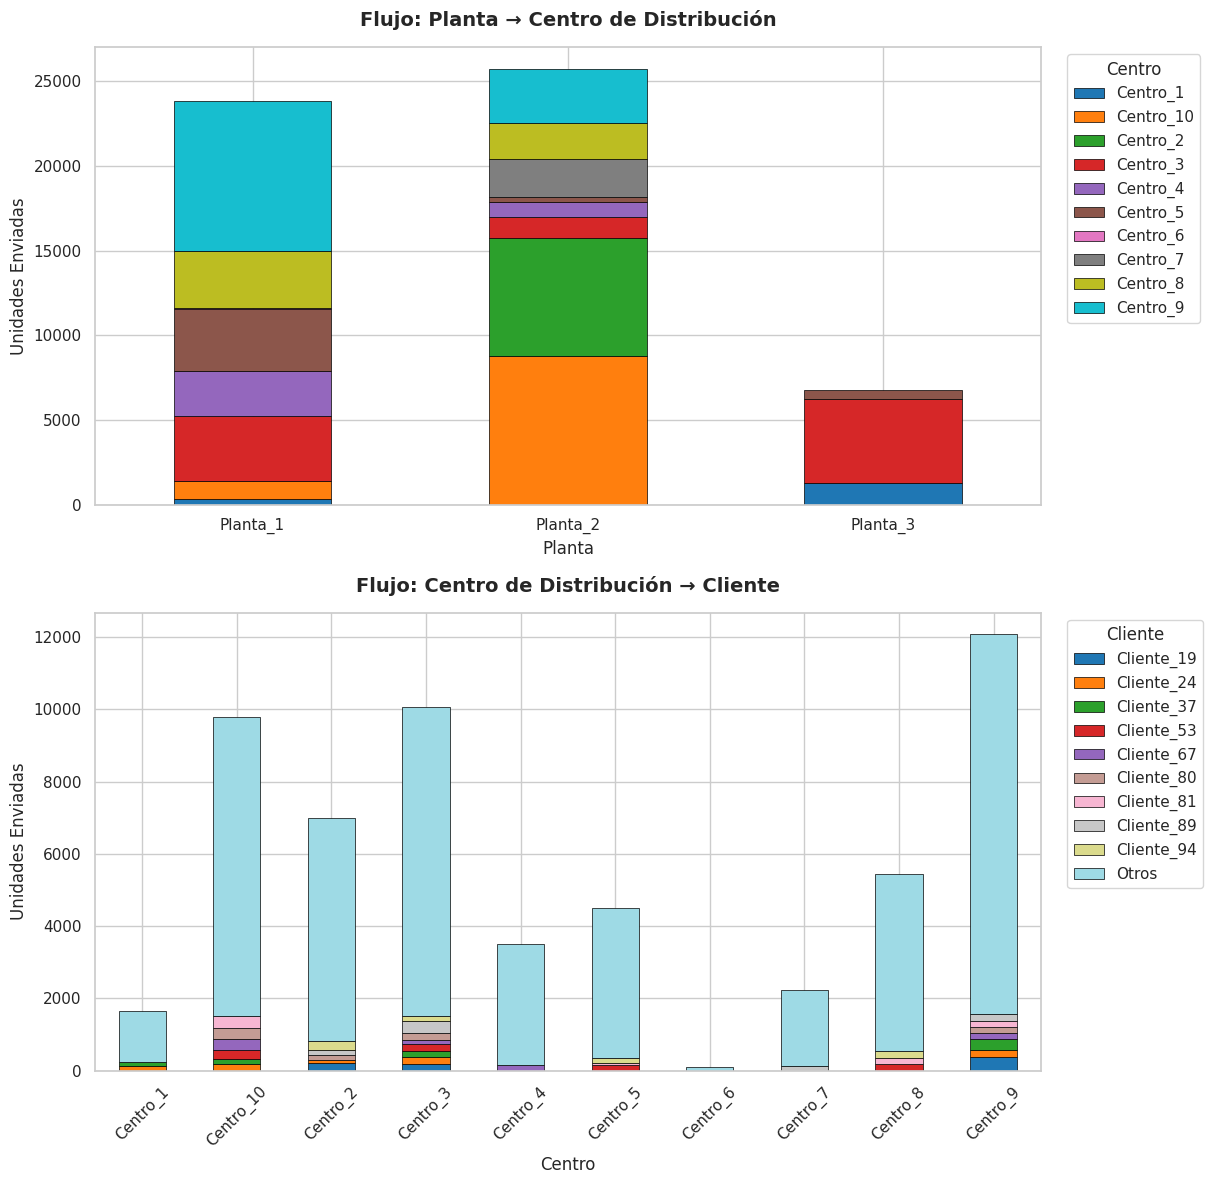

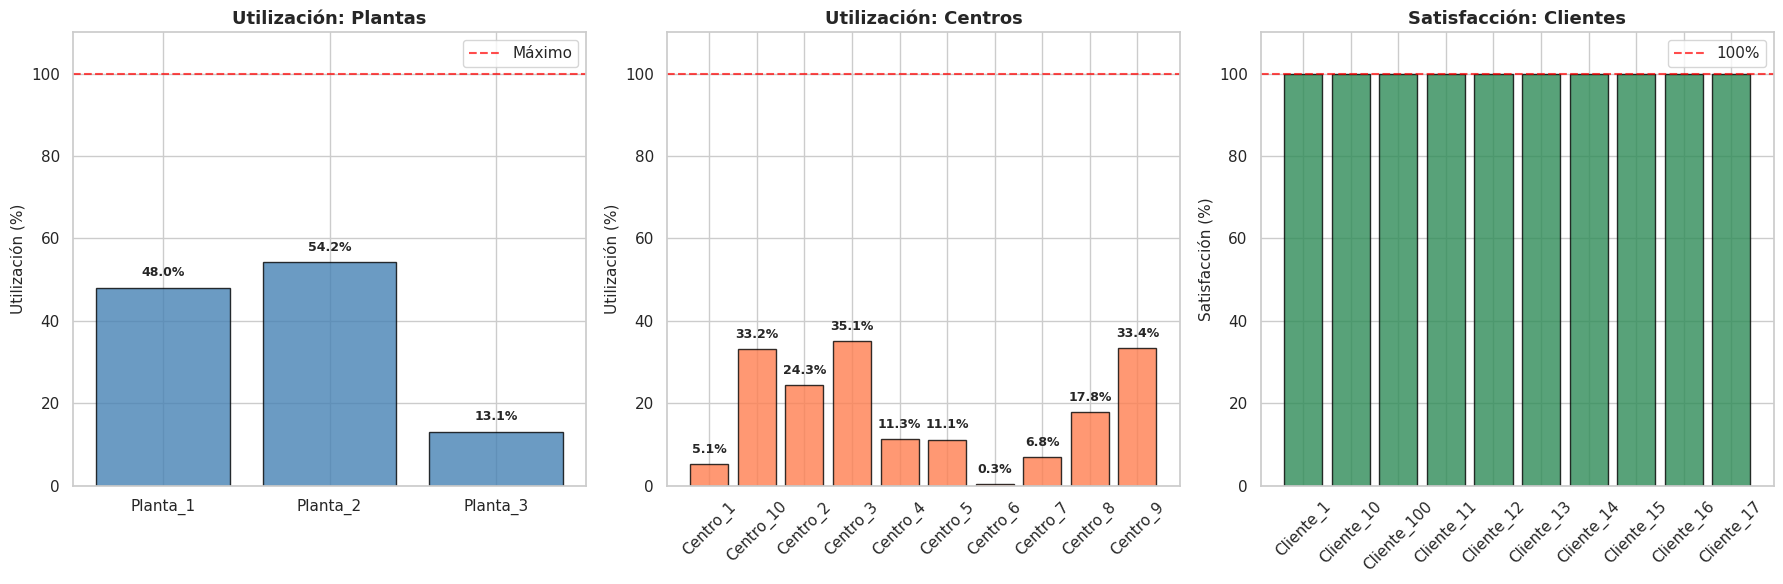

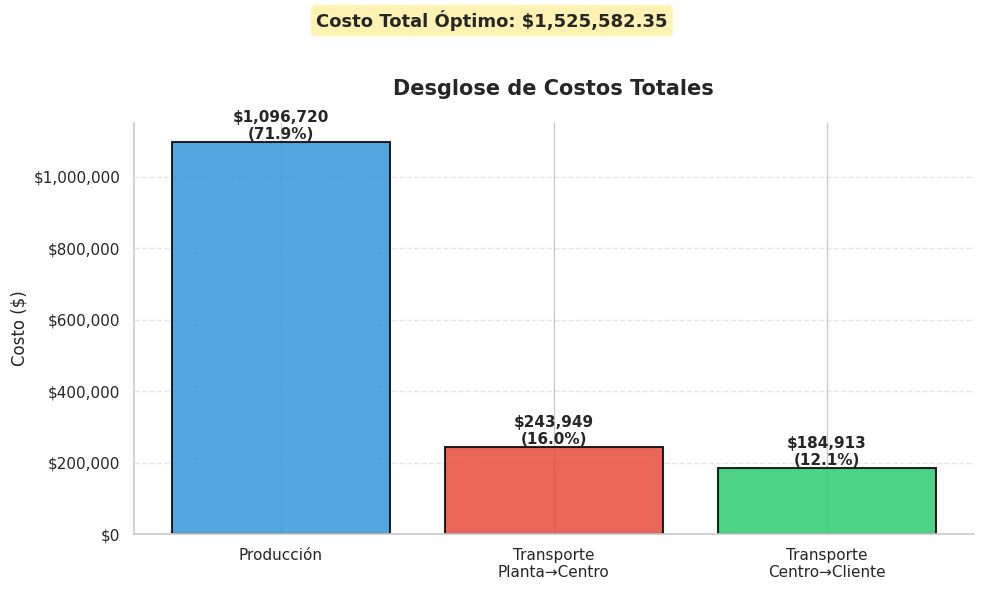


✅ Visualizaciones completadas


In [26]:
# ============================================================================
# 📊 VISUALIZACIÓN DE LA SOLUCIÓN ÓPTIMA
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Configurar estilo
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.dpi'] = 100

print("\n" + "="*70)
print("📊 GENERANDO VISUALIZACIONES DE LA SOLUCIÓN")
print("="*70)

# ============================================================================
# GRÁFICO 1: DISTRIBUCIÓN DE FLUJOS EN LA RED
# ============================================================================

def graficar_flujos():
    """Visualiza los flujos Planta→Centro y Centro→Cliente"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    # --- Flujo Planta → Centro ---
    data_pc = []
    for p in P:
        for c in C:
            flujo = sum(modelo.x[p, c, k].value or 0 for k in K)
            if flujo > 0.01:
                data_pc.append({'Planta': p, 'Centro': c, 'Flujo': flujo})

    if data_pc:
        df_pc = pd.DataFrame(data_pc)
        df_pivot = df_pc.pivot(index='Planta', columns='Centro', values='Flujo').fillna(0)
        df_pivot.plot(kind='bar', stacked=True, ax=axes[0], cmap='tab10',
                     edgecolor='black', linewidth=0.5)
        axes[0].set_title('Flujo: Planta → Centro de Distribución',
                         fontsize=14, fontweight='bold', pad=15)
        axes[0].set_ylabel('Unidades Enviadas', fontsize=12)
        axes[0].set_xlabel('Planta', fontsize=12)
        axes[0].legend(title='Centro', bbox_to_anchor=(1.02, 1), loc='upper left')
        axes[0].tick_params(axis='x', rotation=45 if len(P) > 3 else 0)
    else:
        axes[0].text(0.5, 0.5, 'Sin flujo', ha='center', va='center', fontsize=14)

    # --- Flujo Centro → Cliente ---
    data_cj = []
    for c in C:
        for j in J:
            flujo = sum(modelo.y[c, j, k].value or 0 for k in K)
            if flujo > 0.01:
                data_cj.append({'Centro': c, 'Cliente': j, 'Flujo': flujo})

    if data_cj:
        df_cj = pd.DataFrame(data_cj)

        # Si hay muchos clientes, agrupar los menores
        if len(J) > 10:
            totales_cliente = df_cj.groupby('Cliente')['Flujo'].sum()
            top_clientes = totales_cliente.nlargest(9).index
            df_cj['Cliente_Grupo'] = df_cj['Cliente'].apply(
                lambda x: x if x in top_clientes else 'Otros'
            )
            df_pivot = df_cj.groupby(['Centro', 'Cliente_Grupo'])['Flujo'].sum().unstack(fill_value=0)
        else:
            df_pivot = df_cj.pivot(index='Centro', columns='Cliente', values='Flujo').fillna(0)

        df_pivot.plot(kind='bar', stacked=True, ax=axes[1], cmap='tab20',
                     edgecolor='black', linewidth=0.5)
        axes[1].set_title('Flujo: Centro de Distribución → Cliente',
                         fontsize=14, fontweight='bold', pad=15)
        axes[1].set_ylabel('Unidades Enviadas', fontsize=12)
        axes[1].set_xlabel('Centro', fontsize=12)
        axes[1].legend(title='Cliente', bbox_to_anchor=(1.02, 1), loc='upper left')
        axes[1].tick_params(axis='x', rotation=45 if len(C) > 5 else 0)
    else:
        axes[1].text(0.5, 0.5, 'Sin flujo', ha='center', va='center', fontsize=14)

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

graficar_flujos()

# ============================================================================
# GRÁFICO 2: UTILIZACIÓN DE CAPACIDADES
# ============================================================================

def graficar_utilizacion():
    """Visualiza la utilización de capacidades"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- Utilización de Plantas ---
    util_plantas = []
    for p in P:
        produccion = sum(modelo.x[p, c, k].value or 0 for c in C for k in K)
        capacidad = sum(cap_produccion.get((p, k), 0) for k in K)
        util = (produccion / capacidad * 100) if capacidad > 0 else 0
        util_plantas.append(util)

    bars = axes[0].bar(P, util_plantas, color='steelblue', alpha=0.8, edgecolor='black')
    axes[0].set_title('Utilización: Plantas', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Utilización (%)', fontsize=11)
    axes[0].set_ylim([0, 110])
    axes[0].axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Máximo')
    axes[0].legend()
    axes[0].tick_params(axis='x', rotation=45 if len(P) > 3 else 0)

    # Agregar porcentajes
    for bar, util in zip(bars, util_plantas):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{util:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # --- Utilización de Centros ---
    util_centros = []
    for c in C:
        flujo = sum(modelo.x[p, c, k].value or 0 for p in P for k in K)
        capacidad = sum(cap_almacenamiento.get((c, k), 0) for k in K)
        util = (flujo / capacidad * 100) if capacidad > 0 else 0
        util_centros.append(util)

    bars = axes[1].bar(C, util_centros, color='coral', alpha=0.8, edgecolor='black')
    axes[1].set_title('Utilización: Centros', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Utilización (%)', fontsize=11)
    axes[1].set_ylim([0, 110])
    axes[1].axhline(y=100, color='red', linestyle='--', alpha=0.7)
    axes[1].tick_params(axis='x', rotation=45)

    for bar, util in zip(bars, util_centros):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{util:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # --- Satisfacción de Clientes ---
    satisfaccion = []
    clientes_list = []
    for j in J:
        recibido = sum(modelo.y[c, j, k].value or 0 for c in C for k in K)
        demandado = sum(demanda.get((j, k), 0) for k in K)
        sat = (recibido / demandado * 100) if demandado > 0 else 0
        satisfaccion.append(sat)
        clientes_list.append(j)

    # Calcular estadísticas
    satisfaccion_arr = np.array(satisfaccion)
    rango_satisfaccion = satisfaccion_arr.max() - satisfaccion_arr.min()

    # Decidir tipo de gráfico basado en variabilidad
    if len(J) > 20 and rango_satisfaccion > 5:
        # Histograma para muchos clientes con variación
        axes[2].hist(satisfaccion, bins=15, color='seagreen', alpha=0.8, edgecolor='black')
        axes[2].set_xlabel('Satisfacción (%)', fontsize=11)
        axes[2].set_ylabel('Número de Clientes', fontsize=11)
        axes[2].axvline(x=100, color='red', linestyle='--', alpha=0.7, label='100%')
        axes[2].set_title('Distribución de Satisfacción', fontsize=13, fontweight='bold')
    else:
        # Gráfico de barras individual
        if len(J) <= 15:
            # Mostrar todos los clientes
            bars = axes[2].bar(clientes_list, satisfaccion, color='seagreen',
                             alpha=0.8, edgecolor='black')
            axes[2].tick_params(axis='x', rotation=45)

            # Agregar porcentajes solo si no hay muchos clientes
            for bar, sat in zip(bars, satisfaccion):
                axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                           f'{sat:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')
        else:
            # Top 10 clientes con menor satisfacción + promedio
            sat_dict = dict(zip(clientes_list, satisfaccion))
            top_10_menores = sorted(sat_dict.items(), key=lambda x: x[1])[:10]
            clientes_mostrar = [x[0] for x in top_10_menores]
            sat_mostrar = [x[1] for x in top_10_menores]

            bars = axes[2].bar(clientes_mostrar, sat_mostrar, color='seagreen',
                             alpha=0.8, edgecolor='black')
            axes[2].tick_params(axis='x', rotation=45)
            axes[2].set_title('Top 10 Clientes con Menor Satisfacción', fontsize=13, fontweight='bold')

        axes[2].set_ylabel('Satisfacción (%)', fontsize=11)
        axes[2].set_ylim([0, 110])
        axes[2].axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100%')
        axes[2].set_title('Satisfacción: Clientes', fontsize=13, fontweight='bold')

    axes[2].legend()

    plt.tight_layout()
    plt.show()

graficar_utilizacion()

# ============================================================================
# GRÁFICO 3: DESGLOSE DE COSTOS
# ============================================================================

def graficar_costos():
    """Visualiza el desglose de costos"""

    # Calcular costos
    costo_prod = sum(
        costo_produccion.get((p, k), 0) * (modelo.x[p, c, k].value or 0)
        for p in P for c in C for k in K
    )

    costo_pc = sum(
        costo_planta_centro.get((p, c, k), 0) * (modelo.x[p, c, k].value or 0)
        for p in P for c in C for k in K
    )

    costo_cj = sum(
        costo_centro_cliente.get((c, j, k), 0) * (modelo.y[c, j, k].value or 0)
        for c in C for j in J for k in K
    )

    # Crear gráfico
    fig, ax = plt.subplots(figsize=(10, 6))

    categorias = ['Producción', 'Transporte\nPlanta→Centro', 'Transporte\nCentro→Cliente']
    costos = [costo_prod, costo_pc, costo_cj]
    colores = ['#3498db', '#e74c3c', '#2ecc71']

    bars = ax.bar(categorias, costos, color=colores, alpha=0.85,
                  edgecolor='black', linewidth=1.5)

    # Formato
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    total = sum(costos)
    for bar, costo in zip(bars, costos):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'${costo:,.0f}\n({costo/total*100:.1f}%)',
               ha='center', va='bottom', fontweight='bold', fontsize=11)

    ax.set_title('Desglose de Costos Totales', fontsize=15, fontweight='bold', pad=20)
    ax.set_ylabel('Costo ($)', fontsize=12)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))

    fig.suptitle(f'Costo Total Óptimo: ${total:,.2f}',
                 fontsize=13, fontweight='bold', y=0.98,
                 bbox=dict(boxstyle='round', facecolor='gold', alpha=0.3))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

graficar_costos()

print("\n✅ Visualizaciones completadas")
print("="*70)

# 💭 Reflexiones Finales y Conclusiones

---

## **PATRICIA MARIA ROSAS CALDERON**
*al261538@alumnos.uacj.mx*

### Reflexión sobre el Problema y la Programación Lineal

El problema de optimización de red multinivel de distribución multiproducto representa un desafío complejo que involucra la coordinación simultánea de múltiples plantas manufactureras, centros de distribución, clientes y productos. Esto genera miles de variables de decisión y cientos de restricciones que deben satisfacerse simultáneamente.

Lo que más me impresionó fue cómo la **Programación Lineal** permite transformar un problema aparentemente inmanejable en un modelo matemático estructurado y resoluble. Sin este enfoque sistemático, sería prácticamente imposible encontrar la solución óptima considerando todas las interacciones entre los diferentes niveles de la red.

La formulación matemática nos permitió capturar con precisión las reglas del negocio: restricciones de capacidad que limitan la producción, balance de flujo que garantiza conservación en los centros, y satisfacción exacta de la demanda de clientes.

**Aprendizaje clave:** La Programación Lineal no solo resuelve problemas complejos, sino que nos obliga a entender profundamente la estructura del problema, identificar todas las restricciones relevantes y definir claramente qué estamos optimizando.

---

## **MANUEL FLORES CACHO**
*al263178@alumnos.uacj.mx*

### Reflexión sobre la Complejidad y el Modelado

La **Programación Lineal** nos proporciona un marco matemático riguroso que aprovecha la estructura del problema. Las restricciones no son limitaciones molestas, sino que definen el espacio de soluciones factibles y guían el algoritmo hacia la optimización.

Lo más fascinante fue observar cómo las restricciones se relacionan entre sí: la restricción de balance de flujo conecta las variables de planta-centro con las de centro-cliente, las capacidades de almacenamiento limitan cuánto puede fluir por cada centro, y la demanda de clientes establece objetivos específicos que deben cumplirse exactamente.

El modelo reveló insights valiosos sobre la utilización de capacidades, distribución de costos entre producción y transporte, y las rutas óptimas que minimizan costos considerando todas las restricciones simultáneamente.

**Aprendizaje clave:** La Programación Lineal transforma la intuición en decisiones óptimas cuantificables. No se trata solo de encontrar "una buena solución", sino de garantizar matemáticamente que no existe una mejor opción dentro del espacio factible.

---

## **JAVIER AUGUSTO REBULL SAUCEDO**
*al263483@alumnos.uacj.mx*

### Reflexión sobre la Implementación y el Impacto Práctico

La implementación con Pyomo me permitió apreciar la elegancia con que la programación matemática separa la formulación del problema de la solución algorítmica. Nosotros definimos QUÉ queremos optimizar y CUÁLES son las reglas; el solver determina CÓMO encontrar la solución óptima.

Los resultados validados demuestran que el modelo cumple todas las restricciones: capacidades respetadas, balance de flujo perfecto, y demanda completamente satisfecha. Esto garantiza que la solución es factible y óptima.

**Impacto Práctico:** En un escenario real, este modelo podría reducir costos operativos al identificar rutas de distribución eficientes, mejorar la planificación de capacidad al revelar cuellos de botella, facilitar análisis de sensibilidad para evaluar impactos de cambios, y automatizar decisiones logísticas que actualmente se toman manualmente.

**Aprendizaje clave:** La Programación Lineal no es solo una herramienta académica; es una tecnología de decisión empresarial que convierte datos en estrategia óptima. En cadenas de suministro complejas, la optimización matemática es fundamental para mantener la competitividad.

---

## 🎯 Conclusión del Equipo

Este proyecto demuestra que la **Programación Lineal** es la herramienta apropiada para problemas de optimización con múltiples variables de decisión, restricciones complejas e interrelacionadas, objetivos claros y cuantificables, y relaciones lineales entre variables.

La combinación de **Pyomo** como lenguaje de modelado algebraico y **GLPK** como solver nos permitió expresar el problema de forma natural y obtener la solución óptima de manera eficiente.

Las habilidades desarrolladas son directamente aplicables a problemas reales de logística, producción, finanzas, energía y muchos otros dominios donde la toma de decisiones óptimas es crítica.

---

*Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD)*  
*Universidad Autónoma de Ciudad Juárez (UACJ)*  
*Noviembre 2025*